# MIGROS Location intelligence analysis


*Location intelligence  is the process of deriving meaningful insight from geospatial data relationships to solve a particular business problem.*

This projects addresses a particular problem for retail stores, called _"Branch Network optimisation"_. In this type of analysis, geospatial data are used to determine optimal location for retail branches stores in order to improve spatial coverage and fill gaps in the branch network. 

Here we will try to identify geospatial features that explain Migros Supermarket locations within the canton of Zurich, and feed this information to a machine learning model in order to identify promising locations for addtional branches


In [150]:
# Imports
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import gdal

## Import data


In [278]:
# origin folder
fold_path = "../input_data/intermediate"
assert os.path.exists(fold_path), "input folder does not exist"

# import ref_grid
ref_name = "ref_100m.tif"
file = gdal.Open(os.path.join(fold_path, ref_name))
ref_array = file.GetRasterBand(1).ReadAsArray()

# import all predictors
predictors={}

for file_name in os.listdir(fold_path):
    if file_name.endswith(".tif"):
        file_n = file_name.split('.')[0]
        file = gdal.Open(os.path.join(fold_path, file_name))
        array = file.GetRasterBand(1).ReadAsArray()
        
             
        # mask out of zurich
        array = np.ma.masked_where(ref_array != 1, array)
        
        # normalise
        min_val = np.ma.min(array[array>-9999])
        array = 100*( array  - min_val ) /( np.ma.max(array) - min_val )
   
        
        
        predictors[file_n] = array
        print(f"\n\nimported file {file_n},\n shape : {array.shape},\n max : {np.ma.max(array)}, \n min : {min_val} ")
        plt.pause(0.6)

bus_array.shape

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/numpy/ma/core.py:1021: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)




imported file bus,
 shape : (618, 472),
 max : 100.0, 
 min : 9.635871833779674e-08 


imported file sups_aldi,
 shape : (618, 472),
 max : 100.0, 
 min : 1.769067438295889e-23 


imported file night_image,
 shape : (618, 472),
 max : 100.0, 
 min : 0.15000000596046448 


imported file trains,
 shape : (618, 472),
 max : 100.0, 
 min : 1.0249701531961364e-08 


imported file pop_municipalities,
 shape : (618, 472),
 max : 100.0, 
 min : 362.0 


imported file sups_coop,
 shape : (618, 472),
 max : 100.0, 
 min : 3.169149154665889e-26 


imported file target,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


imported file ref_100m,
 shape : (618, 472),
 max : --, 
 min : 1.0 


imported file streets,
 shape : (618, 472),
 max : 100.0, 
 min : 7.627654667885508e-07 


imported file sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 4.169816821644959e-20 


(497, 462)

In [280]:
# 3d display
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def make_3d_map(array, title=None, mask=None, pos=111, cmap=None):
    xyz[ mask==0 ] = np.NaN
    ny, nx = xyz.shape

    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)

    xv, yv = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(pos, projection='3d')
    ax.plot_surface(xv,yv,xyz)
    fig.suptitle(title)
    ax.grid(False)

## Data exploration



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


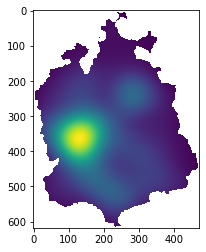

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


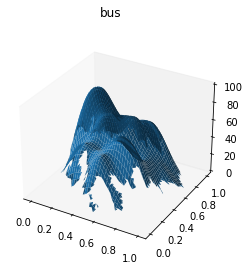

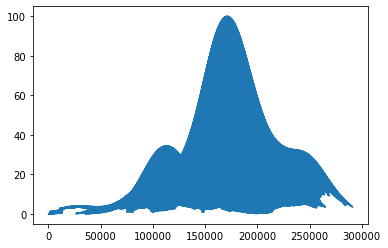



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


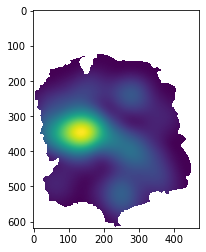

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


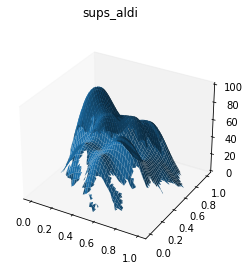

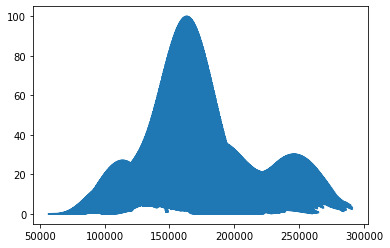



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


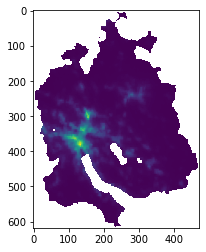

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


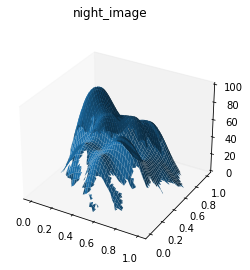

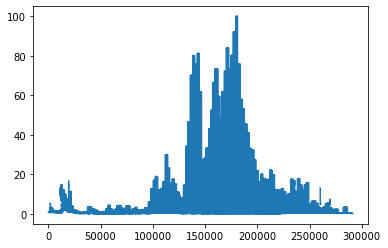



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


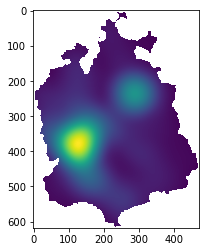

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


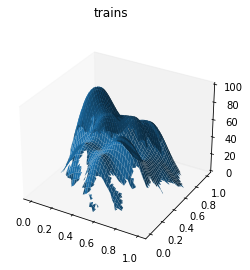

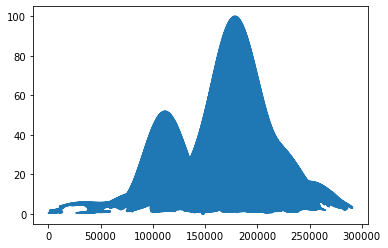



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


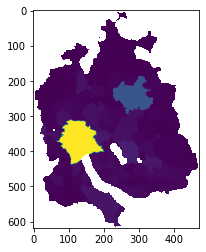

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


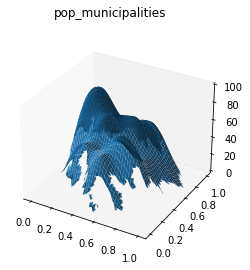

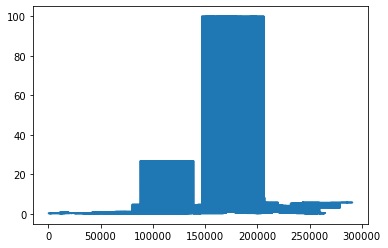



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


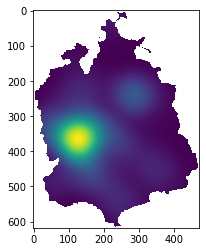

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


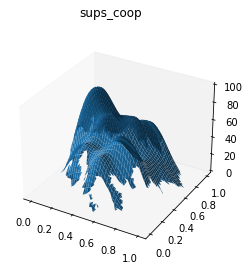

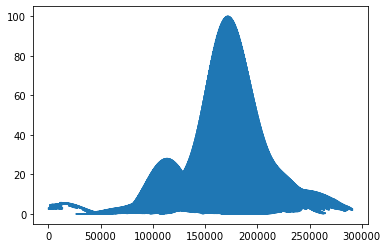



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


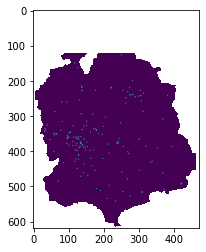

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


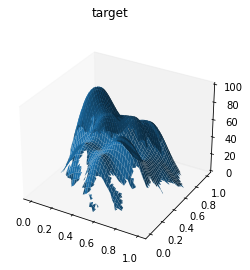

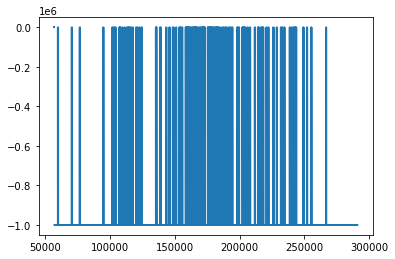



 Predictors: sups_denner,
 shape : (618, 472),
 max : --, 
 min : -- 


/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


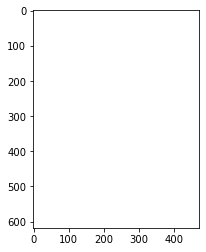

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


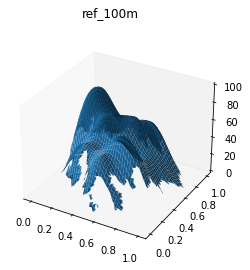

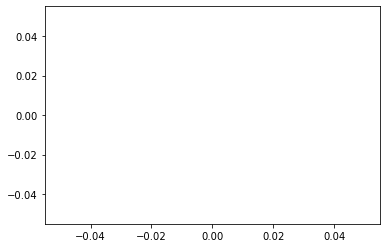



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


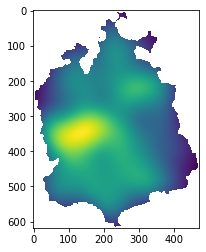

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


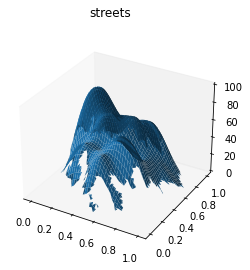

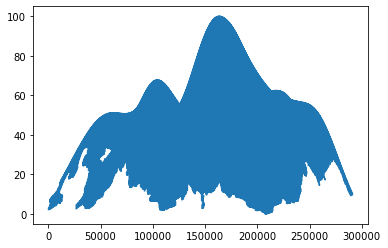



 Predictors: sups_denner,
 shape : (618, 472),
 max : 100.0, 
 min : 0.0 


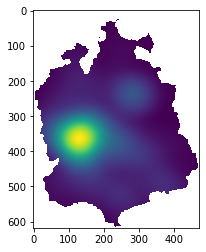

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  app.launch_new_instance()


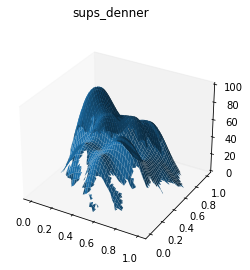

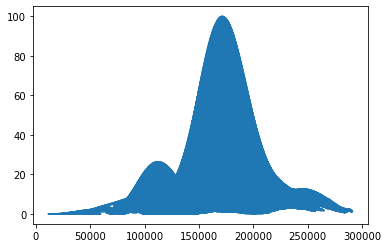

In [281]:
# Draw "flat" histogram and add it to pandas dataframe


for k,v in predictors.items():
    
    pred_arr = v
    # data and 2d array
    array = pred_arr
    min_val = np.ma.min(array[array>-9999])
    print(f"\n\n Predictors: {k},\n shape : {array.shape},\n max : {np.max(array)}, \n min : {min_val} ")
    plt.imshow(pred_arr)
    plt.pause(0.6)
    # 3d map
    make_3d_map(pred_arr, k, ref_array)
    plt.pause(0.6)
    flat_arr = pred_arr.flatten()
    
    plt.plot(flat_arr)
    plt.pause(0.6)
  
    
    # TODO add title and remove axis

In [284]:
# translate array to dataframe

df=pd.DataFrame({"mask" : ref_array.flatten()})

for k,v in predictors.items():
    pred_arr = v
    flat_arr = pred_arr.flatten()
    df[k]=flat_arr
    
# replace -inf with 0
df = df.replace([np.inf, -np.inf], 0)

# remove unwanted rows and columns
df = df.drop(columns = ["target", "ref_100m", "night_image", "pop_municipalities"])

df = df.dropna()

df.head()
df.describe()

,mask,bus,sups_aldi,trains,sups_coop,streets,sups_denner
count,291696.000000,291696.000000,291696.000000,291696.000000,291696.000000,291696.000000,291696.000000
mean,0.594821,52.951759,51.029152,50.722507,48.823391,68.298454,49.466133
std,0.490927,41.397816,43.105030,43.052509,44.461498,30.167200,44.039158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,14.085225,9.314129,8.486170,6.515930,43.973724,7.971196
50%,1.000000,32.469807,31.250340,30.710934,23.519440,62.937853,24.788002
75%,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,1.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


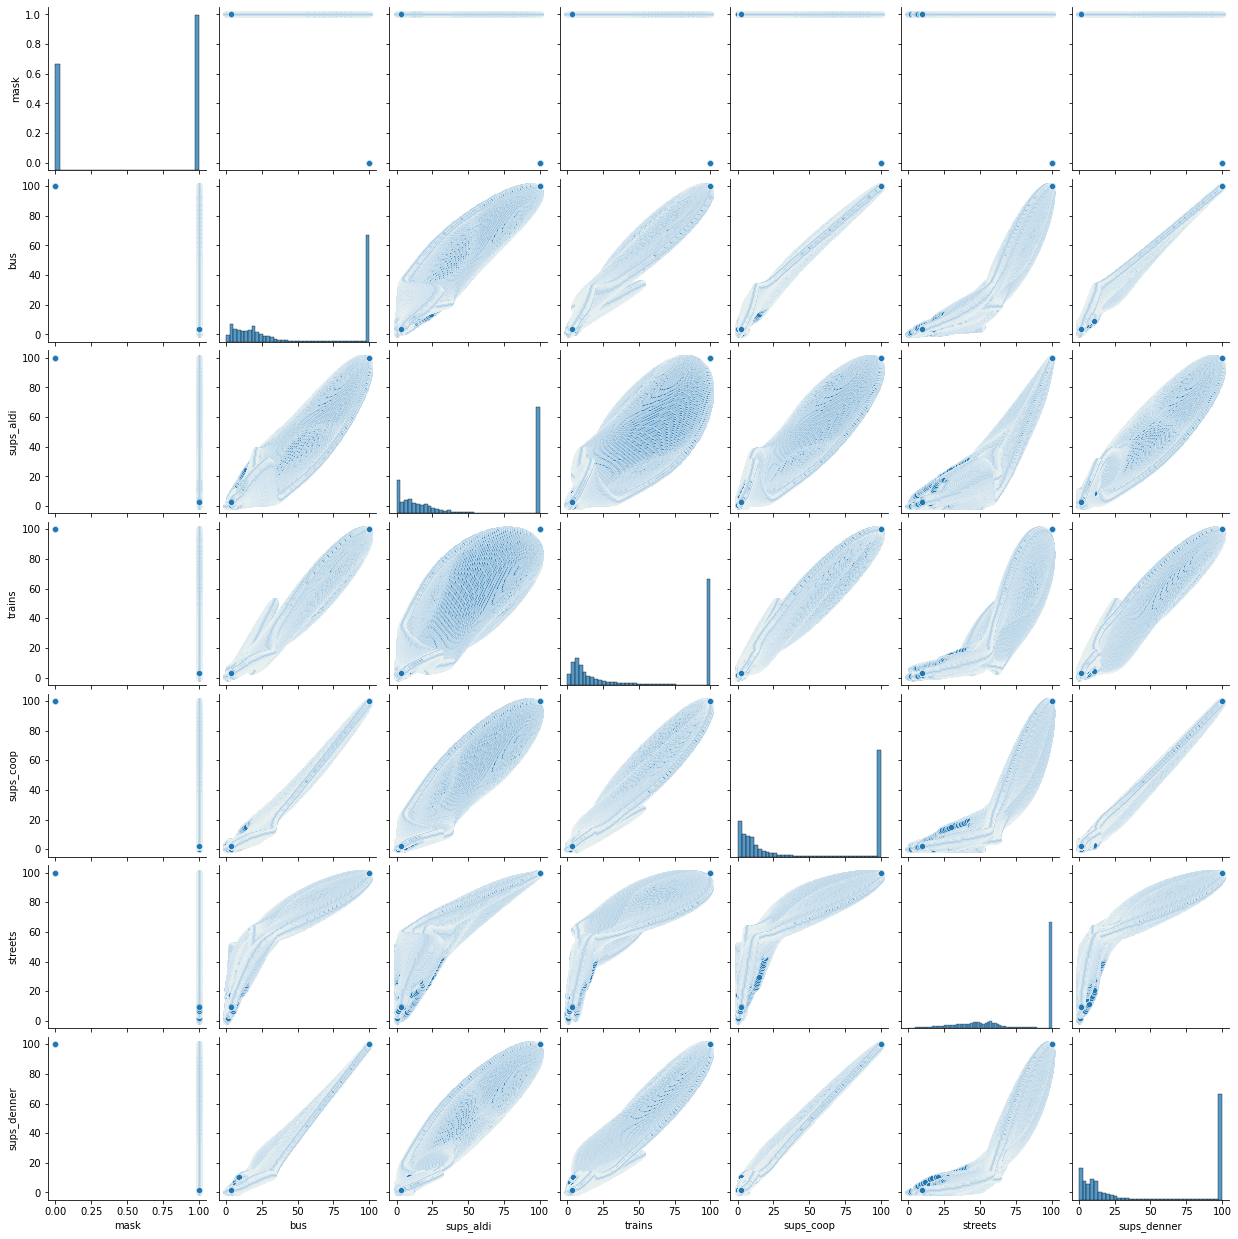

In [285]:
#import seaborn as sns

sns.pairplot(df[1:])

## Feature engineering

/home/matt/anaconda3/envs/migros/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply


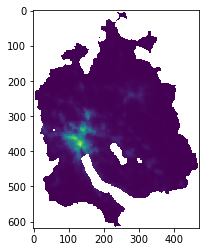

In [315]:
# improving pop density
# import pop density without correction
ref_name = "pop_municipalities.tif"
file = gdal.Open(os.path.join(fold_path, ref_name))
pop_mun = file.GetRasterBand(1).ReadAsArray()

ref_name = "night_image.tif"
file = gdal.Open(os.path.join(fold_path, ref_name))
night_im = file.GetRasterBand(1).ReadAsArray()

# normalise night image values using total population by municipality
fin_im = np.zeros(pop_mun.shape)
for pop in np.unique( pop_mun[pop_mun>0] ):
    
    # select only one municipality at a time
    ma_night_im = np.ma.masked_where( pop_mun != pop, night_im )

    # get conversion factor and apply it to night image
    night_im_sum = np.ma.sum(ma_night_im)
    conv_factor  = pop / night_im_sum
    fin_im = np.where( pop_mun != pop, conv_factor*ma_night_im, fin_im )
    
plt.imshow(fin_im)

## Predicting locations 

## Exploring results

In [ ]:
# (if logistic regression) ROC curve and outliers

# (if random forest) explore tree